In [ ]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

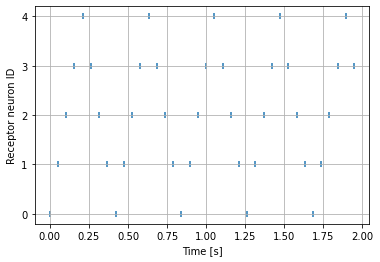

In [ ]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors =5            # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep

# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()

In [ ]:
# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def lif_cic_neuron(I_syn, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    # LIF neuron with a constant input current I_syn
    return {
        'type'    : 'lif_cic',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
    }

def lif_neuron(num_synapses, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
    # LIF neuron with current-based synapses (see lecture)
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
        'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
        'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
    }


def integrate(dt, t, neurons):
    # This function integrates the membrane potential, synaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif_cic':
            dudt = (n['u_rest'] - n['u'] + n['R']*n['I_syn']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] == 'lif':
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            dudt = (n['u_rest'] - n['u'] + n['R']*sum(n['I_syn'])) / n['tau_m']
            n['u'] += dt*dudt

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

def snn_update(dt, t, neurons, connections):
    # This function updates the state of a spiking neural network by calling the functions above
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')
    integrate(dt, t, neurons)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

In [ ]:

#Implement input layer. The input are spikes from 5 different receptors.
in_1 = spike_generator(spikes[0])
in_2 = spike_generator(spikes[1])
in_3 = spike_generator(spikes[2])
in_4 = spike_generator(spikes[3])
in_5 = spike_generator(spikes[4])

# Excitatory LIF-neurons that will spike when the input spikes
n1 = lif_neuron(1)
n2 = lif_neuron(1)
n3 = lif_neuron(1)
n4 = lif_neuron(1)

#Neurons with one excitatory and one inhibitory synapse
n5 = lif_neuron(2)
n6 = lif_neuron(2)
n7 = lif_neuron(2)
n8 = lif_neuron(2)

#the output neuron which should spike if it detects motion to the left
out_l = lif_neuron(4)


n9 =  lif_neuron(1)
n10 = lif_neuron(1)
n11 = lif_neuron(1)
n12 = lif_neuron(1)

n13 = lif_neuron(2)
n14 = lif_neuron(2)
n15 = lif_neuron(2)
n16 = lif_neuron(2)


out_r = lif_neuron(4)

#neuron population
#index = [   0    1      2     3     4    5  6    7   8   9  10  11  12  13  14      15   16  17    18  19   20   21   22 ]
neurons = [in_1, in_2, in_3, in_4, in_5, n1, n2, n3, n4, n5, n6, n7, n8, out_l, n9, n10, n11, n12, n13, n14, n15, n16, out_r]


connections = [
               [5,0,0],
               [6,0,1],
               [7,0,2],
               [8,0,3],

               [9,0,5],
               [10,0,6],
               [11,0,7],
               [12,0,8],

               [9,1,1],
               [10,1,2],
               [11,1,3],
               [12,1,4],

               [13,0,9],
               [13,1,10],
               [13,2,11],
               [13,3,12],

               [14,0,1],
               [15,0,2],
               [16,0,3],
               [17,0,4],

               [18,0,14],
               [19,0,15],
               [20,0,16],
               [21,0,17],

               [18,1,0],
               [19,1,1],
               [20,1,2],
               [21,1,3],

               [22,0,18],
               [22,1,19],
               [22,2,20],
               [22,3,21]
               ]

#from input
n1['w_syn'][0] = 350e-12
n2['w_syn'][0] = 350e-12
n3['w_syn'][0] = 350e-12
n4['w_syn'][0] = 350e-12

#Inhibitory
n5['w_syn'][0] = -350e-12
n6['w_syn'][0] = -350e-12
n7['w_syn'][0] = -350e-12
n8['w_syn'][0] = -350e-12

#excitatory
n5['w_syn'][1] = 350e-12
n6['w_syn'][1] = 350e-12
n7['w_syn'][1] = 350e-12
n8['w_syn'][1] = 350e-12

#to the output
out_l['w_syn'][0] = 200e-12
out_l['w_syn'][1] = 200e-12
out_l['w_syn'][2] = 200e-12
out_l['w_syn'][3] = 200e-12




n9['w_syn'][0]= 350e-12
n10['w_syn'][0]= 350e-12
n11['w_syn'][0]= 350e-12
n12['w_syn'][0]= 350e-12

n13['w_syn'][0]= -350e-12
n14['w_syn'][0]= -350e-12
n15['w_syn'][0]= -350e-12
n16['w_syn'][0]= -350e-12

n13['w_syn'][1]= 350e-12
n14['w_syn'][1]= 350e-12
n15['w_syn'][1]= 350e-12
n16['w_syn'][1]= 350e-12

out_r['w_syn'][0]= 200e-12
out_r['w_syn'][1]= 200e-12
out_r['w_syn'][2]= 200e-12
out_r['w_syn'][3]= 200e-12


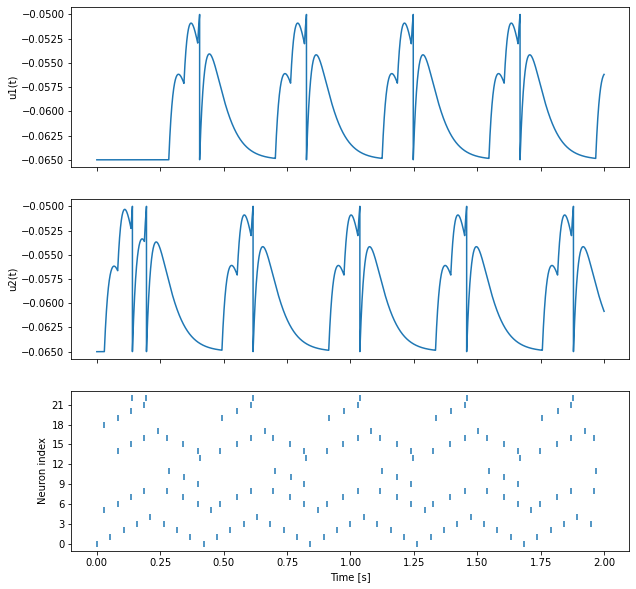

In [ ]:
#set start variables
t = 0
dt = 1e-5

t0 = t
tv = []
u1 = []
u2=[]

t_spike = []
n_spike = []

while t < t0+2:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)
    # Store membrane potentials of out and for plotting/analysis
    tv.append(t)
    u1.append(out_l['u'])
    u2.append(out_r['u'])
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [10, 10]
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax1.plot(tv,u1); ax1.set_ylabel('u1(t)')
ax2.plot(tv,u2); ax2.set_ylabel('u2(t)')
rasterplot(ax3, t_spike, n_spike,'Time [s]','Neuron index')